In [15]:
library(tidyverse)
library(repr)
library(tidymodels)
library(rvest)
library(stringr)
library(DBI)
library(dbplyr)
library(GGally)
options(repr.matrix.max.rows = 6)

# Predicting the Categorical Knowledge Level of a User from their Exam Performance on Electrical DC Machines

## Introduction: 
Regular studying, repetition, and testing can help students learn about an Electrical DC Machine effectively. Students, otherwise known as users, can employ various techniques to improve their knowledge level about Electrical DC Machines. These techniques include how much time they spend studying and repeating the goal-oriented materials, as well as their exam performance on these materials. These techniques can also include the review of related materials to Electrical DC Machines. 

In our study, we ask, "what will the user's knowledge be based on their examination performance on goal-oriented and related materials? 

For this project, we are using the UCI Machine Learning Repository's User Knowledge Modelling Data Set. 
This data set contains 6 columns, 5 of which are input variables and 1 of which is the target variable (the level of user knowledge). Two of the columns list the users' study time, two other columns list the users' exam performance and the last two describe the degree of repetition used and the users' knowledge level. Each row in this dataset contains the values for each of the 6 variables mentioned.

First, we download the url from the website and then reads the excel file into R. Then we transforms the raw data into a tidy dataset by mutating the variables into human-readable ones.

In [2]:
#Read training data set into R

library(readxl)
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00257/Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.xls"

download.file(url, "data.xls")
training_data <- read_excel("data.xls", sheet = 2) #'sheet = 2' is for training data

training_data_tidy <- select(training_data, STG:UNS) %>%
rename("goal_study_time" = STG, "goal_repetition_number_of_user" = SCG, "related_study_time" = STR, "related_exam_performance" = LPR, "goal_exam_performance" = PEG, "user_knowledge" = UNS) %>%
mutate(user_knowledge = as.factor(user_knowledge))

levels(training_data_tidy $ user_knowledge) <- c('High', 'Low', 'Middle', 'Very Low')

training_data_tidy

New names:
* `` -> ...7
* `` -> ...8



goal_study_time,goal_repetition_number_of_user,related_study_time,related_exam_performance,goal_exam_performance,user_knowledge
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.00,0.00,0.00,0.00,0.00,Very Low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
⋮,⋮,⋮,⋮,⋮,⋮
0.54,0.82,0.71,0.29,0.77,High
0.50,0.75,0.81,0.61,0.26,Middle
0.66,0.90,0.76,0.87,0.74,High


In [3]:
#Read testing data set into R

url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00257/Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.xls"

download.file(url, "data.xls")
testing_data <- read_excel("data.xls", sheet = 3) #'sheet = 3' is for testing data

testing_data_tidy <- select(testing_data, STG:UNS) %>%
rename("goal_study_time" = STG, "goal_repetition_number_of_user" = SCG, "related_study_time" = STR, "related_exam_performance" = LPR, "goal_exam_performance" = PEG, "user_knowledge" = UNS) %>%
mutate(user_knowledge = as.factor(user_knowledge))

testing_data_tidy

New names:
* `` -> ...7
* `` -> ...8



goal_study_time,goal_repetition_number_of_user,related_study_time,related_exam_performance,goal_exam_performance,user_knowledge
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.00,0.10,0.50,0.26,0.05,Very Low
0.05,0.05,0.55,0.60,0.14,Low
0.08,0.18,0.63,0.60,0.85,High
⋮,⋮,⋮,⋮,⋮,⋮
0.56,0.60,0.77,0.13,0.32,Low
0.66,0.68,0.81,0.57,0.57,Middle
0.68,0.64,0.79,0.97,0.24,Middle


The data contains 6 variables as listed:

In [11]:
tibble(Variables = c("goal_study_time", "goal_repetition_number_of_user", "related_study_time", "related_exam_performance", "goal_exam_performance", "user_knowledge"), Interpretation = c("The degree of study time for goal object materials", "The degree of repetition number of user for goal object materials", "The degree of study time of user for related objects with goal object", "The exam performance of user for related objects with goal object", "The exam performance of user for goal objects", "The knowledge level of user"))

Variables,Interpretation
<chr>,<chr>
goal_study_time,The degree of study time for goal object materials
goal_repetition_number_of_user,The degree of repetition number of user for goal object materials
related_study_time,The degree of study time of user for related objects with goal object
related_exam_performance,The exam performance of user for related objects with goal object
goal_exam_performance,The exam performance of user for goal objects
user_knowledge,The knowledge level of user


In [4]:
knowledge_proportions_train <- training_data_tidy %>%
group_by(user_knowledge) %>%
summarise(n = n()) %>%
mutate(percent = 100*n/nrow(training_data_tidy))

knowledge_proportions_test <- testing_data_tidy %>%
group_by(user_knowledge) %>%
summarise(n = n()) %>%
mutate(percent = 100*n/nrow(testing_data_tidy))

knowledge_proportions_train
knowledge_proportions_test

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



user_knowledge,n,percent
<fct>,<int>,<dbl>
High,63,24.418605
Low,83,32.170543
Middle,88,34.108527
Very Low,24,9.302326


user_knowledge,n,percent
<fct>,<int>,<dbl>
High,39,26.89655
Low,46,31.72414
Middle,34,23.44828
Very Low,26,17.93103


## Methods:

### Data Analysis:
We will use a K-nearest neighbour classification with cross-validation to conduct our data analysis. The KNN classification model will need to be trained, evaluated, and tuned with training and testing sets before predicting user knowledge. By using KNN classification with cross-validation, we will plot the accuracy of K and find the highest accuracy to find the K value we want; this will lead to a more effective model. For this analysis, we will employ three columns from the data set. Two predictor variables, the examination performance of the goal object materials and related objects, will be used to predict the users' knowledge level (very low, low, medium, high). 

### Visualization: 
To visualize our results, we plan on using the "user knowledge" category with three colours encoded into a scatterplot . On the x-axis will be the goal-oriented examination performance and the related objects examination performance on the y-axis.
 
### Expectations and Impacts:
We predict that a higher the user knowledge, the better the exam performance on both study objects, whether it is directly or indirectly related to Electrical DC Machines-- a positive, medium-strength relationship. Thus, a lower user knowledge should mean a lower exam performance on both study objects. By finding the threshold for exam score needed to be classified as a "high user knowledge level", users studying Electical DC Circuits can be better informed on what score they should be aiming for on an examination. 

### Future questions:
Were there statistics that were not included in the given dataset that could improve the effectiveness of the model?
Do certain statistics influence the user knowledge more? If so, would there be abetter weight function to use in the classification engine?
How does study time or repetition of the different objects affect user knowledge? 
Would more data collection into the related objects involved in exam performance help differentiate which indirect objects lead to better user knowledge?

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



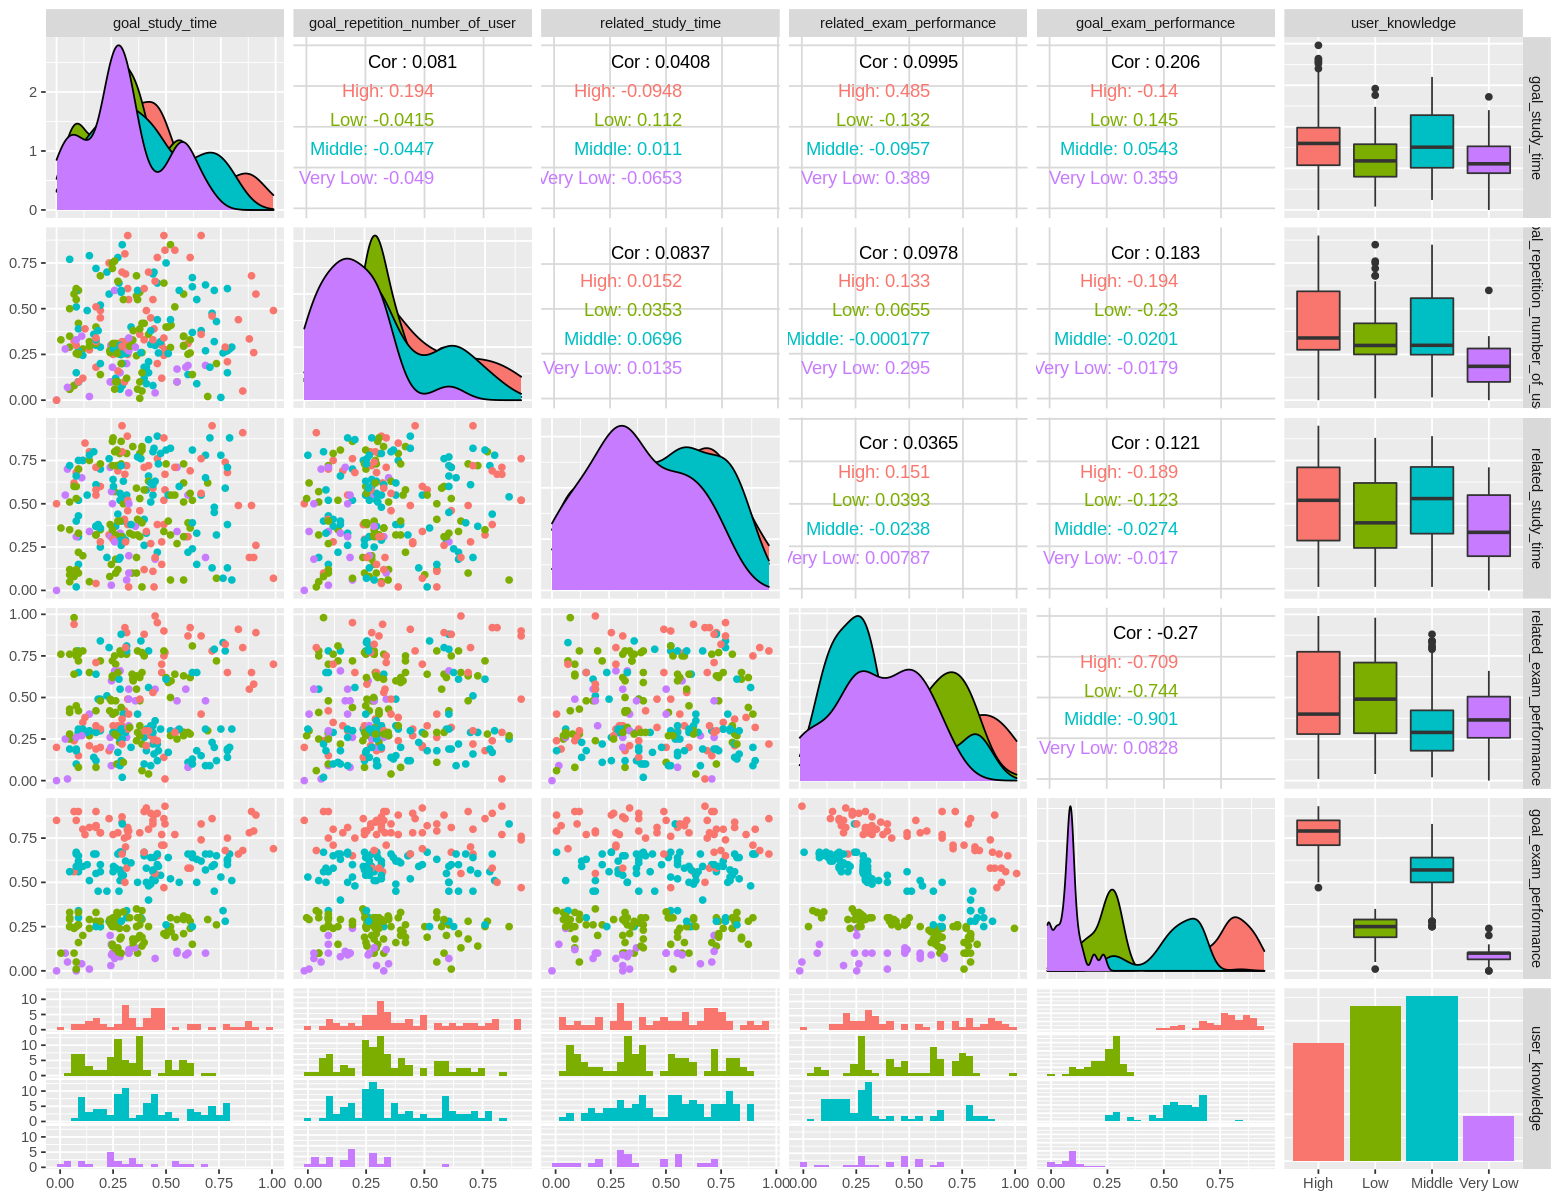

In [23]:
knowledge_ggpairs <- training_data_tidy %>%
ggpairs(aes(color = user_knowledge))

knowledge_ggpairs

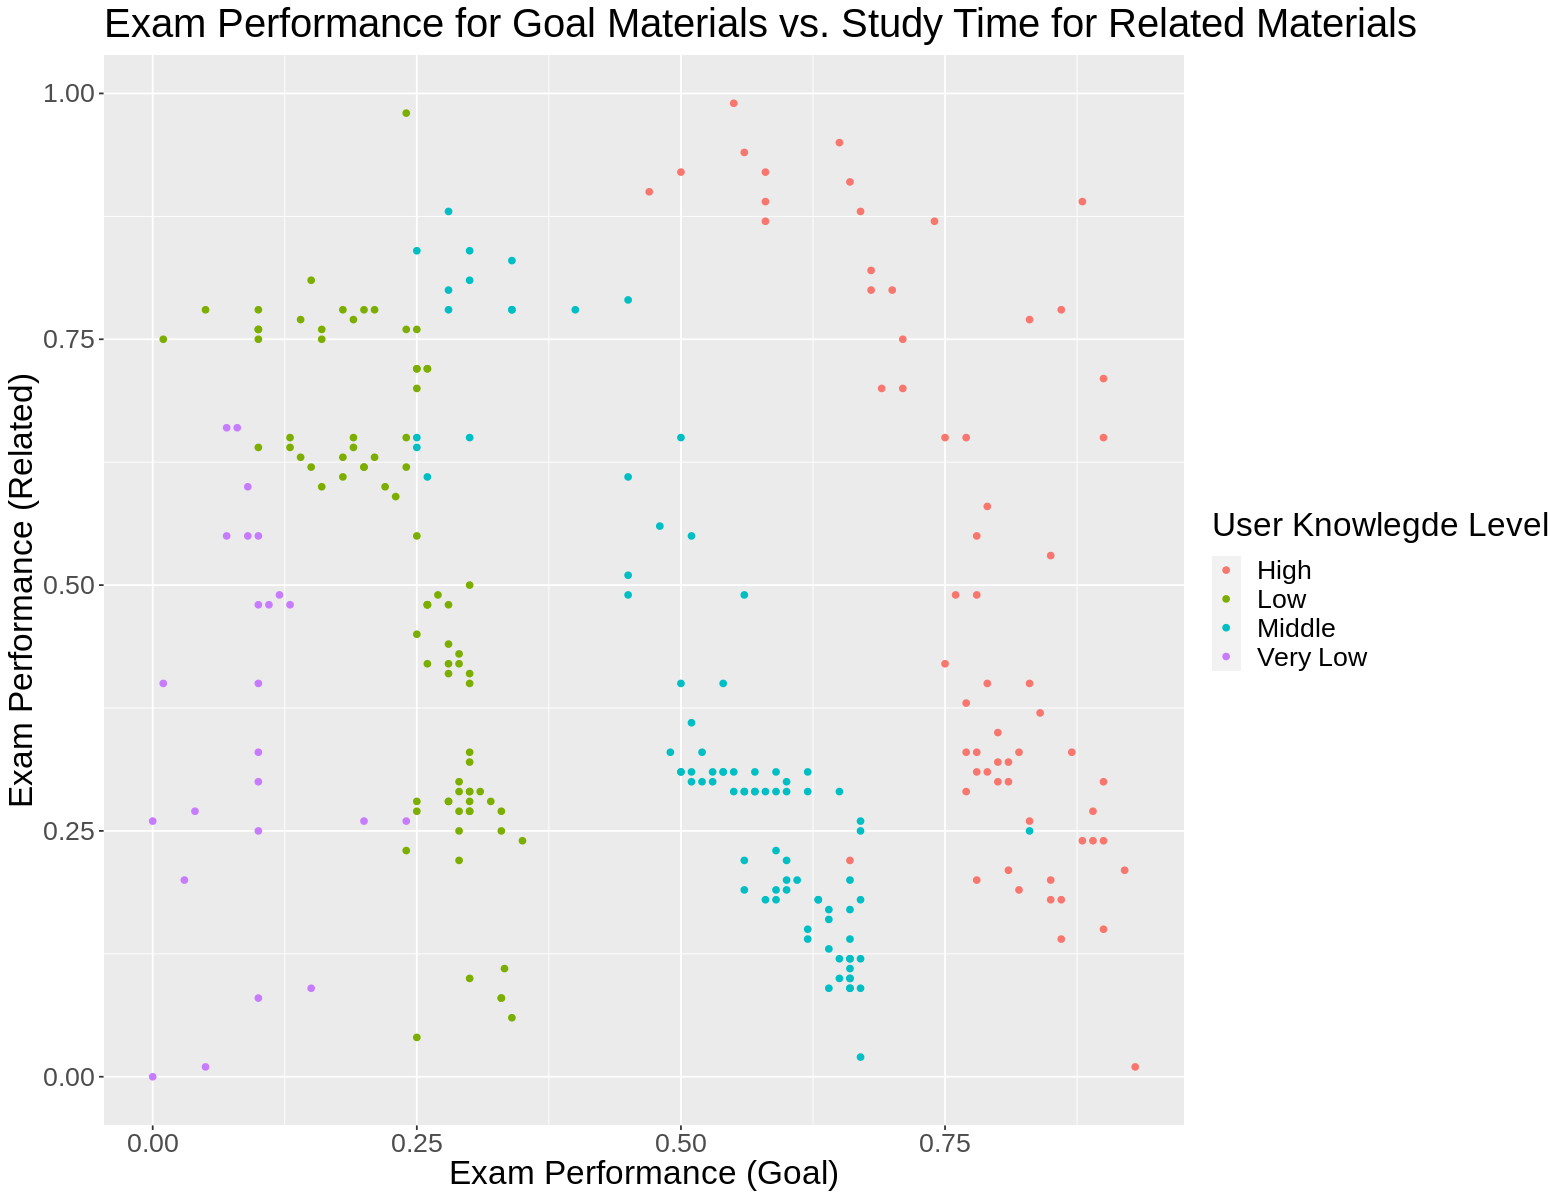

In [5]:
#Check if there is relationship between both types of exam performance and user knowledge

options(repr.plot.width = 13, repr.plot.height = 10)

plot <- ggplot(training_data_tidy, aes(x = goal_exam_performance, y = related_exam_performance, color = user_knowledge)) + 
    geom_point() +
    labs(x = "Exam Performance (Goal)", y = "Exam Performance (Related)", color = "User Knowlegde Level") +
    theme(text = element_text(size = 20)) + 
    ggtitle("Exam Performance for Goal Materials vs. Study Time for Related Materials") 

plot

From the plot above we can see that at where both types of exam performance are low, the user knowledge level are generally very low (purple dots), and the high user knowledge generally exists at area where both types of exam performance are high. In conclusion, this illustrates that there is a relationship between both types of exam performance and the level of user knowledge as well as both types of exam performance should be good predictors to predict the level of user knowledge.

! Fold3: internal: No observations were detected in `truth` for level(s): 'Very L...



neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.9538348,5,0.01563576,Model01
2,accuracy,multiclass,0.9538348,5,0.01563576,Model02
3,accuracy,multiclass,0.9455329,5,0.01309863,Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
13,accuracy,multiclass,0.9222239,5,0.01657857,Model13
14,accuracy,multiclass,0.9222239,5,0.01657857,Model14
15,accuracy,multiclass,0.8991383,5,0.01296801,Model15


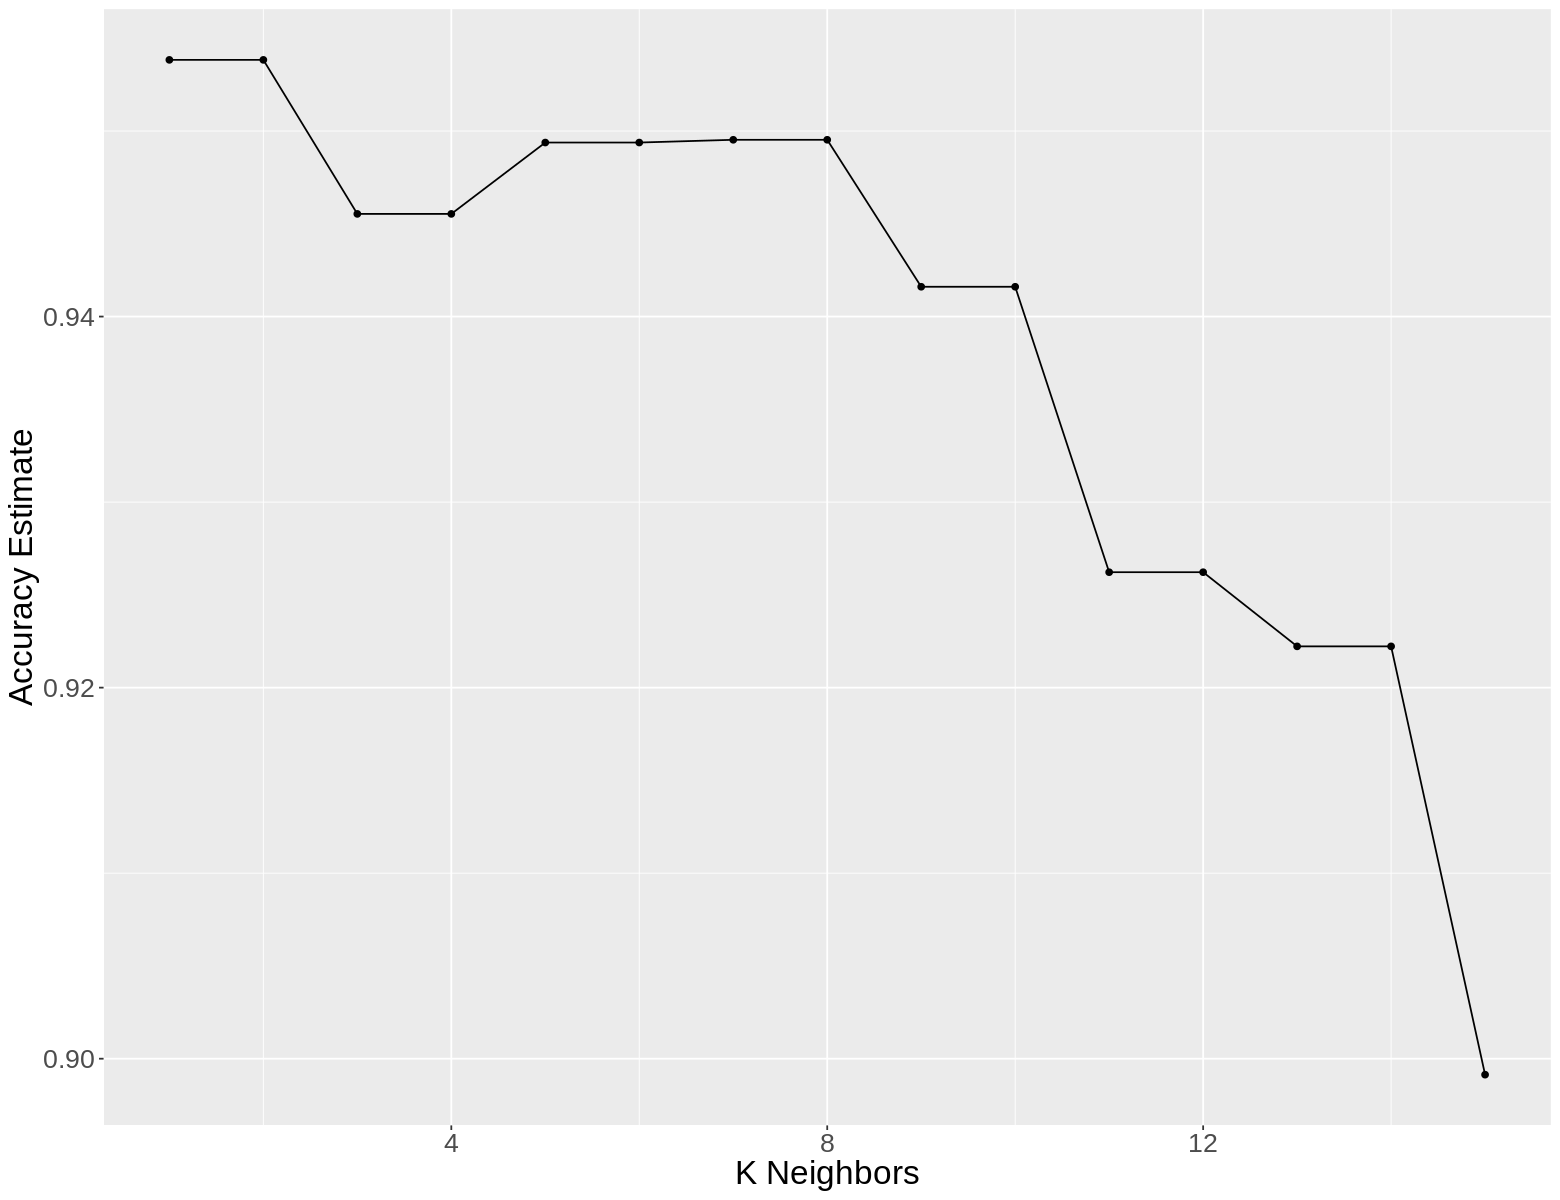

In [24]:
#Find the K-value that gives the highest accuracy

set.seed(1)

knowledge_recipe <- recipe(user_knowledge ~ goal_exam_performance + related_exam_performance, data = training_data_tidy) %>%
step_scale(all_predictors()) %>%
step_center(all_predictors())
                                            
knowledge_vfold <- vfold_cv(training_data_tidy, v = 5, strata = user_knowledge)
                                       
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbor = tune()) %>%
set_engine("kknn") %>%
set_mode("classification")
                  
k_vals <- tibble(neighbors = seq(from = 1, to = 15, by = 1)) 

knn_results <- workflow() %>%
add_recipe(knowledge_recipe) %>%
add_model(knn_tune) %>%
tune_grid(resamples = knowledge_vfold, grid = k_vals) %>%
collect_metrics()
          
accuracies <- knn_results %>%
filter(.metric == "accuracy")
    
accuracies

accuracy_plot <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
geom_point() +
geom_line() +
labs(x = "K Neighbors", y = "Accuracy Estimate")+
theme(text = element_text(size = 20))

accuracy_plot

In [25]:
#Build model with the best K-value

bestk_spec <- nearest_neighbor(weight_func = "rectangular", neighbor = 2) %>%
set_engine("kknn") %>%
set_mode("classification")

bestk_fit <- workflow() %>%
add_recipe(knowledge_recipe) %>%
add_model(bestk_spec) %>%
fit(data = training_data_tidy)

bestk_fit

#Finally, using testing data set to predict

bestk_predictions <- predict(bestk_fit, testing_data_tidy) %>%
bind_cols(testing_data_tidy)

bestk_predictions

bestk_metrics <- bestk_predictions %>%
metrics(truth = user_knowledge, estimate = .pred_class)

bestk_conf_mat <- bestk_predictions %>%
conf_mat(truth = user_knowledge, estimate = .pred_class)

bestk_conf_mat

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~2, kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.06589147
Best kernel: rectangular
Best k: 2

.pred_class,goal_study_time,goal_repetition_number_of_user,related_study_time,related_exam_performance,goal_exam_performance,user_knowledge
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
Very Low,0.00,0.10,0.50,0.26,0.05,Very Low
Low,0.05,0.05,0.55,0.60,0.14,Low
High,0.08,0.18,0.63,0.60,0.85,High
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Low,0.56,0.60,0.77,0.13,0.32,Low
Middle,0.66,0.68,0.81,0.57,0.57,Middle
Low,0.68,0.64,0.79,0.97,0.24,Middle


          Truth
Prediction High Low Middle Very Low
  High       38   0      0        0
  Low         0  42      3        2
  Middle      1   3     31        0
  Very Low    0   1      0       24

In [26]:
bestk_nrows <- nrow(bestk_predictions)
nrows

ERROR: Error in eval(expr, envir, enclos): object 'nrows' not found


In [ ]:
bestk_accuracy <- ((38 + 42 + 31 + 24)/bestk_nrows) * 100
bestk_accuracy

After summing up all the accuracies for each level of user knowledge and dividing them by the total number of rows, we get an accuracy of up to 93%! This is a very high accuracy rate for a classification model, and indicates that the model is very reliable as well. 

Now, let's try to predict some made-up data using this model and see if it works well. We want to see if the predicted result will be corresponding to the column named "observed_knowledge_level" or not.

In [ ]:
knowledge_sample <- tibble(observed_knowledge_level = c("High", "Middle", "Low", "Very Low"), 
                      goal_exam_performance = c(0.95, 0.62, 0.37, 0.14), 
                     related_exam_performance = c(0.87, 0.50, 0.43, 0.28))

prediction <- predict(bestk_fit, knowledge_sample)

prediction_table <- bind_cols(knowledge_sample, prediction) %>%
rename(predicted_knowledge_level = .pred_class) %>%
mutate(observed_knowledge_level = as.factor(observed_knowledge_level))

prediction_table

As expected, the outcome is very optimal as the model did a great job predicting the class.